##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# A Tour of Oryx

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/oryx/examples/a_tour_of_oryx"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/spinoffs/oryx/examples/notebooks/a_tour_of_oryx.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/spinoffs/oryx/examples/notebooks/a_tour_of_oryx.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/spinoffs/oryx/examples/notebooks/a_tour_of_oryx.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## What is Oryx?

Oryx is an experimental library that extends [JAX](https://github.com/google/jax) to applications ranging from building and training complex neural networks to approximate Bayesian inference in deep generative models. Like JAX provides `jit`, `vmap`, and `grad`, Oryx provides a set of **composable function transformations** that enable writing simple code and transforming it to build complexity while staying completely interoperable with JAX.

JAX can only safely transform pure, functional code (i.e. code without side-effects). While pure code can be easier to write and reason about, "impure" code can often be more concise and more easily expressive.

At its core, Oryx is a library that enables "augmenting" pure functional code to accomplish tasks like defining state or pulling out intermediate values. Its goal is to be as thin of a layer on top of JAX as possible, leveraging JAX's minimalist approach to numerical computing. Oryx is conceptually divided into several "layers", each building on the one below it.

The source code for Oryx can be found [on GitHub](https://github.com/tensorflow/probability/tree/master/spinoffs/oryx).

## Setup

In [2]:
!pip install -q oryx 1>/dev/null

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import jax
import jax.numpy as jnp
from jax import random
from jax import vmap
from jax import jit
from jax import grad

import oryx

tfd = oryx.distributions

state = oryx.core.state
ppl = oryx.core.ppl

inverse = oryx.core.inverse
ildj = oryx.core.ildj
plant = oryx.core.plant
reap = oryx.core.reap
sow = oryx.core.sow
unzip = oryx.core.unzip

nn = oryx.experimental.nn
mcmc = oryx.experimental.mcmc
optimizers = oryx.experimental.optimizers

## Layer 0: Base function transformations



At its base, Oryx defines several new function transformations. These transformations are implemented using JAX's tracing machinery and are interoperable with existing JAX transformations like `jit`, `grad`, `vmap`, etc.

### Automatic function inversion
`oryx.core.inverse` and `oryx.core.ildj` are function transformations that can programatically invert a function and compute its inverse log-det Jacobian (ILDJ) respectively. These transformations are useful in probabilistic modeling for computing log-probabilities using the change-of-variable formula. There are limitations on the types of functions they are compatible with, however (see [the documentation](https://tensorflow.org/probability/oryx/api_docs/python/oryx/core/interpreters/inverse) for more details).

In [4]:
def f(x):
  return jnp.exp(x) + 2.
print(inverse(f)(4.))  # ln(2)
print(ildj(f)(4.)) # -ln(2)

0.6931472
-0.6931472


### Harvest
`oryx.core.harvest` enables tagging values in functions along with the ability to collect them, or "reap" them, and the ability to inject values in their place, or "planting" them. We tag values using the `sow` function.

In [5]:
def f(x):
  y = sow(x + 1., name='y', tag='intermediate')
  return y ** 2
print('Reap:', reap(f, tag='intermediate')(1.))  # Pulls out 'y'
print('Plant:', plant(f, tag='intermediate')(dict(y=5.), 1.))  # Injects 5. for 'y'

Reap: {'y': DeviceArray(2., dtype=float32)}
Plant: 25.0


### Unzip
`oryx.core.unzip` splits a function in two along a set of values tagged as intermediates, then returning the functions `init_f` and `apply_f`. `init_f` takes in a key argument and returns the intermediates. `apply_f` returns a function that takes in the intermediates and returns the original function's output.

In [6]:
def f(key, x):
  w = sow(random.normal(key), tag='variable', name='w')
  return w * x
init_f, apply_f = unzip(f, tag='variable')(random.PRNGKey(0), 1.)

The `init_f` function runs `f` but only returns its variables.

In [7]:
init_f(random.PRNGKey(0))

{'w': DeviceArray(-0.20584226, dtype=float32)}

`apply_f` takes a set of variables as its first input and executes `f` with the given set of variables.

In [8]:
apply_f(dict(w=2.), 2.)  # Runs f with `w = 2`.


DeviceArray(4., dtype=float32)

## Layer 1: Higher level transformations

Oryx builds off the low-level inverse, harvest, and unzip function transformations to offer several higher-level transformations for writing stateful computations and for probabilistic programming.

### Stateful functions (`core.state`)
We're often interested in expressing stateful computations where we initialize a set of parameters and express a computation in terms of the parameters. In `oryx.core.state`, Oryx provides an `init` transformation that converts a function into one that initializes a `Module`, a container for state.

`Module`s resemble Pytorch and TensorFlow `Module`s except that they are immutable.

In [9]:
def make_dense(dim_out):
  def forward(x, init_key=None):
    w_key, b_key = random.split(init_key)
    dim_in = x.shape[0]
    w = state.variable(random.normal(w_key, (dim_in, dim_out)), name='w')
    b = state.variable(random.normal(w_key, (dim_out,)), name='b')
    return jnp.dot(x, w) + b
  return forward

layer = state.init(make_dense(5))(random.PRNGKey(0), jnp.zeros(2))
print('layer:', layer)
print('layer.w:', layer.w)
print('layer.b:', layer.b)

layer: FunctionModule(dict_keys(['w', 'b']))
layer.w: [[-2.6105583   0.03385283  1.0863334  -1.4802988   0.48895672]
 [ 1.062516    0.5417484   0.0170228   0.2722685   0.30522448]]
layer.b: [0.59902626 0.2172144  2.4202902  0.03266738 1.2164948 ]


`Module`s are registered as JAX pytrees and can be used as inputs to JAX transformed functions. Oryx provides a convenient `call` function that executes a `Module`.

In [10]:
vmap(state.call, in_axes=(None, 0))(layer, jnp.ones((5, 2)))

DeviceArray([[-0.94901603,  0.7928156 ,  3.5236464 , -1.1753628 ,
               2.010676  ],
             [-0.94901603,  0.7928156 ,  3.5236464 , -1.1753628 ,
               2.010676  ],
             [-0.94901603,  0.7928156 ,  3.5236464 , -1.1753628 ,
               2.010676  ],
             [-0.94901603,  0.7928156 ,  3.5236464 , -1.1753628 ,
               2.010676  ],
             [-0.94901603,  0.7928156 ,  3.5236464 , -1.1753628 ,
               2.010676  ]], dtype=float32)

The `state` API also enables writing stateful updates (like running averages) using the `assign` function. The resulting `Module` has an `update` function with an input signature that is the same as the `Module`'s `__call__` but creates a new copy of the `Module` with an updated state.

In [11]:
def counter(x, init_key=None):
  count = state.variable(0., key=init_key, name='count')
  count = state.assign(count + 1., name='count')
  return x + count
layer = state.init(counter)(random.PRNGKey(0), 0.)
print(layer.count)
updated_layer = layer.update(0.)
print(updated_layer.count) # Count has advanced!
print(updated_layer.call(1.))

0.0
1.0
3.0



### Probabilistic programming

In `oryx.core.ppl`, Oryx provides a set of tools built on top of `harvest` and `inverse` which aim to make writing and transforming probabilistic programs intuitive and easy.

In Oryx, a probabilistic program is a JAX function that takes a source of randomness as its first argument and returns a sample from a distribution, i.e, `f :: Key -> Sample`. In order to write these programs, Oryx wraps [TensorFlow Probability](https://www.tensorflow.org/probability) distributions and provides a simple function `random_variable` that converts a distribution into a probabilistic program.

In [12]:
def sample(key):
  return ppl.random_variable(tfd.Normal(0., 1.))(key)
sample(random.PRNGKey(0))

DeviceArray(-0.20584235, dtype=float32)

What can we do with probabilistic programs? The simplest thing would be to take a probabilistic program (i.e. a sampling function) and convert it into one that provides the log-density of a sample.

In [13]:
ppl.log_prob(sample)(1.)

DeviceArray(-1.4189385, dtype=float32)

The new log-probability function is compatible with other JAX transformations like `vmap` and `grad`.

In [14]:
grad(lambda s: vmap(ppl.log_prob(sample))(s).sum())(jnp.arange(10.))

DeviceArray([-0., -1., -2., -3., -4., -5., -6., -7., -8., -9.], dtype=float32)

Using the `ildj` transformation, we can compute `log_prob` of programs that invertibly transform samples.

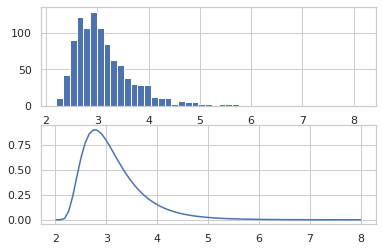

In [15]:
def sample(key):
  x = ppl.random_variable(tfd.Normal(0., 1.))(key)
  return jnp.exp(x / 2.) + 2.
_, ax = plt.subplots(2)
ax[0].hist(jit(vmap(sample))(random.split(random.PRNGKey(0), 1000)),
    bins='auto')
x = jnp.linspace(0, 8, 100)
ax[1].plot(x, jnp.exp(jit(vmap(ppl.log_prob(sample)))(x)))
plt.show()

We can tag intermediate values in a probabilistic program with names and obtain joint sampling and joint log-prob functions.

In [16]:
def sample(key):
  z_key, x_key = random.split(key)
  z = ppl.random_variable(tfd.Normal(0., 1.), name='z')(z_key)
  x = ppl.random_variable(tfd.Normal(z, 1.), name='x')(x_key)
  return x
ppl.joint_sample(sample)(random.PRNGKey(0))

{'x': DeviceArray(-1.1076484, dtype=float32),
 'z': DeviceArray(0.14389044, dtype=float32)}

Oryx also has a `joint_log_prob` function that composes `log_prob` with `joint_sample`.

In [17]:
ppl.joint_log_prob(sample)(dict(x=0., z=0.))

DeviceArray(-1.837877, dtype=float32)

To learn more, see the [documentation](https://tensorflow.org/probability/oryx/api_docs/python/oryx/core/ppl/transformations).

## Layer 2: Mini-libraries

Building further on top of the layers that handle state and probabilistic programming, Oryx provides experimental mini-libraries tailored for specific applications like deep learning and Bayesian inference.

### Neural networks

In `oryx.experimental.nn`, Oryx provides a set of common neural network `Layer`s that fit neatly into the `state` API. These layers are built for single examples (not batches) but override batch behaviors to handle patterns like running averages in batch normalization. They also enable passing keyword arguments like `training=True/False` into modules.

`Layer`s are initialized from a `Template` like `nn.Dense(200)` using `state.init`.

In [18]:
layer = state.init(nn.Dense(200))(random.PRNGKey(0), jnp.zeros(50))
print(layer, layer.params.kernel.shape, layer.params.bias.shape)

Dense(200) (50, 200) (200,)


A `Layer` has a `call` method that runs its forward pass.

In [19]:
layer.call(jnp.ones(50)).shape

(200,)

Oryx also provides a `Serial` combinator.

In [20]:
mlp_template = nn.Serial([
  nn.Dense(200), nn.Relu(),
  nn.Dense(200), nn.Relu(),
  nn.Dense(10), nn.Softmax()
])
# OR
mlp_template = (
    nn.Dense(200) >> nn.Relu()
    >> nn.Dense(200) >> nn.Relu()
    >> nn.Dense(10) >> nn.Softmax())
mlp = state.init(mlp_template)(random.PRNGKey(0), jnp.ones(784))
mlp(jnp.ones(784))

DeviceArray([0.16362445, 0.21150257, 0.14715882, 0.10425295, 0.05952952,
             0.07531884, 0.08368199, 0.0376978 , 0.0159679 , 0.10126514],            dtype=float32)

We can interleave functions and combinators to create a flexible neural network "meta language".

In [21]:
def resnet(template):
  def forward(x, init_key=None):
    layer = state.init(template, name='layer')(init_key, x)
    return x + layer(x)
  return forward

big_resnet_template = nn.Serial([
  nn.Dense(50)
  >> resnet(nn.Dense(50) >> nn.Relu())
  >> resnet(nn.Dense(50) >> nn.Relu())
  >> nn.Dense(10)
])
network = state.init(big_resnet_template)(random.PRNGKey(0), jnp.ones(784))
network(jnp.ones(784))

DeviceArray([-0.03828401,  0.9046303 ,  1.6083915 , -0.17005858,
              3.889552  ,  1.7427744 , -1.0567027 ,  3.0192878 ,
              0.28983995,  1.7103616 ], dtype=float32)

### Optimizers

In `oryx.experimental.optimizers`, Oryx provides a set of first-order optimizers, built using the `state` API. Their design is based off of JAX's [`optix` library](https://jax.readthedocs.io/en/latest/jax.experimental.optix.html), where optimizers maintain state about a set of gradient updates. Oryx's version manages state using the `state` API.

In [22]:
network_key, opt_key = random.split(random.PRNGKey(0))
def autoencoder_loss(network, x):
  return jnp.square(network.call(x) - x).mean()
network = state.init(nn.Dense(200) >> nn.Relu() >> nn.Dense(2))(network_key, jnp.zeros(2))
opt = state.init(optimizers.adam(1e-4))(opt_key, network, network)
g = grad(autoencoder_loss)(network, jnp.zeros(2))

g, opt = opt.call_and_update(network, g)
network = optimizers.optix.apply_updates(network, g)

### Markov chain Monte Carlo

In `oryx.experimental.mcmc`, Oryx provides a set of Markov Chain Monte Carlo (MCMC) kernels. MCMC is an approach to approximate Bayesian inference where we draw samples from a Markov chain whose stationary distribution is the posterior distribution of interest.

Oryx's MCMC library builds on both the `state` and `ppl` API.

In [23]:
def model(key):
  return jnp.exp(ppl.random_variable(tfd.MultivariateNormalDiag(
      jnp.zeros(2), jnp.ones(2)))(key))

#### Random walk Metropolis

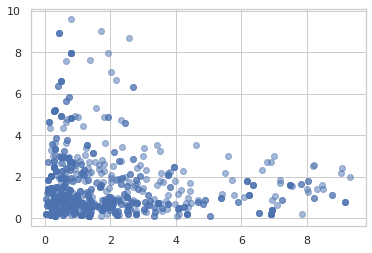

In [24]:
samples = jit(mcmc.sample_chain(mcmc.metropolis(
    ppl.log_prob(model),
    mcmc.random_walk()), 1000))(random.PRNGKey(0), jnp.ones(2))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.show()

#### Hamiltonian Monte Carlo

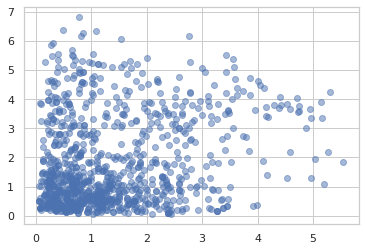

In [25]:
samples = jit(mcmc.sample_chain(mcmc.hmc(
    ppl.log_prob(model)), 1000))(random.PRNGKey(0), jnp.ones(2))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.show()